In [65]:
import pandas as pd
import numpy as np

In [98]:
df = pd.read_parquet('../sampling/data/combined_dataset.parquet')

In [99]:
df.columns

Index(['id', 'message_id', 'campaign_id', 'message_type', 'client_id',
       'channel_x', 'category', 'platform', 'email_provider', 'stream', 'date',
       'sent_at', 'is_opened', 'opened_first_time_at', 'opened_last_time_at',
       'is_clicked', 'clicked_first_time_at', 'clicked_last_time_at',
       'is_unsubscribed', 'unsubscribed_at', 'is_hard_bounced',
       'hard_bounced_at', 'is_soft_bounced', 'soft_bounced_at',
       'is_complained', 'complained_at', 'is_blocked', 'blocked_at',
       'is_purchased', 'purchased_at', 'created_at', 'updated_at',
       'campaign_type', 'channel_y', 'topic', 'started_at', 'finished_at',
       'total_count', 'ab_test', 'warmup_mode', 'hour_limit', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_test', 'position', 'first_purchase_date'],
      dtype='object')

In [100]:
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

category                        100.000000
blocked_at                       99.987077
complained_at                    99.979904
purchased_at                     99.963483
soft_bounced_at                  99.772836
unsubscribed_at                  99.760683
ab_test                          99.470029
hard_bounced_at                  99.302323
clicked_first_time_at            98.940947
clicked_last_time_at             98.940947
hour_limit                       98.450634
position                         94.945711
is_test                          94.945473
platform                         85.346888
opened_first_time_at             81.270615
opened_last_time_at              81.270615
first_purchase_date              79.501673
email_provider                   36.300421
finished_at                       9.037907
started_at                        7.588133
total_count                       7.588133
warmup_mode                       7.327771
subject_length                    5.054527
subject_wit

In [101]:
df['topic'].value_counts(dropna=False)

topic
sale out                      1529081
abandoned view                  30144
None                            22422
recent purchase                 13338
abandoned cart                  13261
abandoned category              13108
order ready for pickup          11090
order created                   10128
subscribed                       9743
welcome campaign                 7839
order reminder                   6309
order cancelled                  6062
added to wish list               2965
abandoned search                 2622
happy birthday                   1888
welcome letter                   1726
profile updated                  1423
offer after purchase             1389
order pickup still pending       1020
event                             522
bonuses expired                   386
order shipped                     181
leave review                      154
price drop                         79
back in stock                       4
Name: count, dtype: int64

In [ ]:
df = df.drop(columns=['category'])
df = df.dropna(subset=['sent_at', 'date'])

In [36]:
df.sent_at

0         2023-03-29 14:51:41
1         2023-03-29 14:51:46
2         2023-03-29 14:51:48
3         2023-03-29 14:51:50
4         2023-03-29 14:51:54
                  ...        
1686879   2023-03-29 08:23:08
1686880   2023-03-29 08:06:49
1686881   2023-03-29 09:06:58
1686882   2023-03-29 09:10:44
1686883   2023-03-29 09:57:21
Name: sent_at, Length: 1686884, dtype: datetime64[us]

In [37]:
# df = df.dropna(subset=['sent_at'])

In [38]:
# Ensure datetime columns are in datetime format
time_cols = [
    'sent_at', 'opened_first_time_at', 'opened_last_time_at',
    'clicked_first_time_at', 'clicked_last_time_at', 'purchased_at'
]
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

# Sort messages by client_id and sent time
df = df.sort_values(['client_id', 'sent_at'])

In [59]:
df.columns

Index(['id', 'message_id', 'campaign_id', 'message_type', 'client_id',
       'channel_x', 'category', 'platform', 'email_provider', 'stream', 'date',
       'sent_at', 'is_opened', 'opened_first_time_at', 'opened_last_time_at',
       'is_clicked', 'clicked_first_time_at', 'clicked_last_time_at',
       'is_unsubscribed', 'unsubscribed_at', 'is_hard_bounced',
       'hard_bounced_at', 'is_soft_bounced', 'soft_bounced_at',
       'is_complained', 'complained_at', 'is_blocked', 'blocked_at',
       'is_purchased', 'purchased_at', 'created_at', 'updated_at',
       'campaign_type', 'channel_y', 'topic', 'started_at', 'finished_at',
       'total_count', 'ab_test', 'warmup_mode', 'hour_limit', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_test', 'position', 'first_purchase_date',
       'time_to_open_hours', 'time_to_click_hours', 'sent_count

In [72]:
print(f"Number of instances with not clicked but purchased: {df[(df['is_clicked'] == 0) & (df['is_purchased'] == 1)].shape[0]}")
print(f"Number of instances with not opened but purchased: {df[(df['is_opened'] == 0) & (df['is_purchased'] == 1)].shape[0]}")
print(f"Number of instances with not opened but clicked: {df[(df['is_opened'] == 0) & (df['is_clicked'] == 1)].shape[0]}")

Number of instances with not clicked but purchased: 0
Number of instances with not opened but purchased: 45
Number of instances with not opened but clicked: 1954


We can assume that clients couldn't buy the products without messages, maybe in a few cases message was not opened, but the link was clicked, but it seems like a technical issue of tracking. The results above seem like the only way of buying products was the campaign messages.

In [61]:


def engineer_message_features(df):
    """
    Engineer message-level features for marketing analytics.
    Includes client-level, channel-level, and market-level activity.
    Uses closed='left' to prevent target leakage.
    """

    df = df.copy()

    # --- Data preparation ---
    df['sent_at'] = pd.to_datetime(df['sent_at'], errors='coerce')
    df = df.dropna(subset=['sent_at'])
    df = df.sort_values(['client_id', 'sent_at', 'message_id']).drop_duplicates(subset=['client_id', 'sent_at'])
    df = df.reset_index(drop=True)

    print(f"Processing {len(df):,} messages for {df['client_id'].nunique():,} clients")

    # ---------------------------------------------------------
    # Create all binary indicators upfront
    # ---------------------------------------------------------
    print("Creating indicator variables...")
    df['hour'] = df['sent_at'].dt.hour
    df['weekday'] = df['sent_at'].dt.weekday
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_working_hours'] = df['hour'].between(9, 18).astype(int)
    
    # Channel indicators
    df['is_email'] = (df['channel_x'] == 'email').astype(int)
    df['is_push'] = (df['channel_x'] == 'push').astype(int)
    
    # Campaign type indicators
    df['is_bulk'] = (df['campaign_type'] == 'bulk').astype(int)
    df['is_triggered'] = (df['campaign_type'] == 'triggered').astype(int)
    df['is_transactional'] = (df['campaign_type'] == 'transactional').astype(int)
    
    # Message position within campaign
    df['msg_position_in_campaign'] = (
        df.groupby(['client_id', 'campaign_id']).cumcount() + 1
    )
    
    # Days since last message
    df['days_since_last_msg'] = (
        df.groupby('client_id')['sent_at']
        .diff()
        .dt.total_seconds()
        .div(86400)
    )
    
    # Set index once
    df_indexed = df.set_index('sent_at')

    # =====================================================
    # Rolling features - all in one go
    # =====================================================
    print("Computing rolling features...")
    
    rolling_configs = [
        # (column_name, output_prefix, aggregation_function, days, period_name)
        ('message_id', 'sent_count', 'count', '7d', '1w'),
        ('message_id', 'sent_count', 'count', '30d', '1m'),
        
        # Channel-specific counts
        ('is_email', 'sent_count_email', 'sum', '7d', '1w'),
        ('is_email', 'sent_count_email', 'sum', '30d', '1m'),
        ('is_push', 'sent_count_push', 'sum', '7d', '1w'),
        ('is_push', 'sent_count_push', 'sum', '30d', '1m'),
        
        # Message intervals
        ('days_since_last_msg', 'avg_interval', 'mean', '7d', '1w'),
        ('days_since_last_msg', 'avg_interval', 'mean', '30d', '1m'),
        
        # Campaign types
        ('is_bulk', 'bulk_count', 'sum', '7d', '1w'),
        ('is_bulk', 'bulk_count', 'sum', '30d', '1m'),
        ('is_triggered', 'triggered_count', 'sum', '7d', '1w'),
        ('is_triggered', 'triggered_count', 'sum', '30d', '1m'),
        ('is_transactional', 'transactional_count', 'sum', '7d', '1w'),
        ('is_transactional', 'transactional_count', 'sum', '30d', '1m'),
        
        # Subject features
        ('subject_length', 'avg_subject_len', 'mean', '7d', '1w'),
        ('subject_length', 'avg_subject_len', 'mean', '30d', '1m'),
        
        # Temporal patterns
        ('is_weekend', 'weekend_ratio', 'mean', '7d', '1w'),
        ('is_weekend', 'weekend_ratio', 'mean', '30d', '1m'),
        ('is_working_hours', 'working_hours_ratio', 'mean', '7d', '1w'),
        ('is_working_hours', 'working_hours_ratio', 'mean', '30d', '1m'),
    ]
    
    # Subject-specific features
    for feat in ['personalization', 'bonuses', 'saleout', 'discount', 'deadline', 'emoji']:
        col = f'subject_with_{feat}'
        if col in df.columns:
            rolling_configs.extend([
                (col, f'subject_{feat}_prop', 'mean', '7d', '1w'),
                (col, f'subject_{feat}_prop', 'mean', '30d', '1m'),
            ])
    
    # A/B test and warmup
    for mode_col in ['ab_test', 'warmup_mode']:
        if mode_col in df.columns:
            rolling_configs.extend([
                (mode_col, f'{mode_col}_count', 'sum', '7d', '1w'),
                (mode_col, f'{mode_col}_count', 'sum', '30d', '1m'),
            ])
    
    # Compute all rolling features
    for col, prefix, agg_func, days, period in rolling_configs:
        if col not in df_indexed.columns:
            print(f"  Warning: Column '{col}' not found, skipping...")
            continue
            
        output_col = f'{prefix}_{period}'
        
        try:
            rolling_obj = df_indexed.groupby('client_id')[col].rolling(days, closed='left')
            
            if agg_func == 'count':
                result = rolling_obj.count()
            elif agg_func == 'sum':
                result = rolling_obj.sum()
            elif agg_func == 'mean':
                result = rolling_obj.mean()
            else:
                raise ValueError(f"Unknown aggregation: {agg_func}")
            
            df[output_col] = result.reset_index(level=0, drop=True).values
            
        except Exception as e:
            print(f"  Error computing {output_col}: {e}")
            df[output_col] = np.nan

    # =====================================================
    # Unique campaigns (requires custom logic)
    # =====================================================
    print("Computing unique campaign counts...")
    for days, period in [('7d', '1w'), ('30d', '1m')]:
        df[f'unique_campaigns_{period}'] = (
            df_indexed.groupby('client_id')['campaign_id']
            .rolling(days, closed='left')
            .apply(lambda x: x.nunique(), raw=False)
            .reset_index(level=0, drop=True)
            .values
        )

    # =====================================================
    # Days since last message per channel
    # =====================================================
    print("Computing channel-specific message intervals...")
    for ch in ['email', 'push']:
        df[f'days_since_last_{ch}'] = np.nan
        mask = df['channel_x'] == ch
        if mask.any():
            df.loc[mask, f'days_since_last_{ch}'] = (
                df[mask].groupby('client_id')['sent_at']
                .diff()
                .dt.total_seconds()
                .div(86400)
                .values
            )

    # =====================================================
    # Market-level features
    # =====================================================
    print("Computing market-level message volumes...")
    
    df_market = (
        df.groupby(pd.Grouper(key='sent_at', freq='1H'))
        .agg(total_msgs=('message_id', 'count'))
        .sort_index()
    )

    for lookback, suffix in [('6H', '6h'), ('1D', '1d'), ('7D', '1w'), ('30D', '1m')]:
        df_market[f'market_avg_msgs_{suffix}'] = (
            df_market['total_msgs']
            .rolling(lookback, closed='left')
            .mean()
        )

    # Merge back
    df = pd.merge_asof(
        df.sort_values('sent_at'),
        df_market,
        left_on='sent_at',
        right_index=True,
        direction='backward'
    )

    print("Message feature engineering complete!")
    print(f"Total features: {len(df.columns)}")
    print(f"New rolling features: {len([c for c in df.columns if any(p in c for p in ['_1w', '_1m', '_6h', '_1d'])])}")
    
    return df


# Usage
df = engineer_message_features(df)

Processing 1,680,048 messages for 39,983 clients
Creating indicator variables...
Computing rolling features...
Computing unique campaign counts...
Computing channel-specific message intervals...
Computing market-level message volumes...


/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_79724/3907375359.py:169: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(pd.Grouper(key='sent_at', freq='1H'))
/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_79724/3907375359.py:177: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling(lookback, closed='left')


Message feature engineering complete!
Total features: 120
New rolling features: 49


In [34]:
list(df.columns)

['id',
 'message_id',
 'campaign_id',
 'message_type',
 'client_id',
 'channel_x',
 'category',
 'platform',
 'email_provider',
 'stream',
 'date',
 'sent_at',
 'is_opened',
 'opened_first_time_at',
 'opened_last_time_at',
 'is_clicked',
 'clicked_first_time_at',
 'clicked_last_time_at',
 'is_unsubscribed',
 'unsubscribed_at',
 'is_hard_bounced',
 'hard_bounced_at',
 'is_soft_bounced',
 'soft_bounced_at',
 'is_complained',
 'complained_at',
 'is_blocked',
 'blocked_at',
 'is_purchased',
 'purchased_at',
 'created_at',
 'updated_at',
 'campaign_type',
 'channel_y',
 'topic',
 'started_at',
 'finished_at',
 'total_count',
 'ab_test',
 'warmup_mode',
 'hour_limit',
 'subject_length',
 'subject_with_personalization',
 'subject_with_deadline',
 'subject_with_emoji',
 'subject_with_bonuses',
 'subject_with_discount',
 'subject_with_saleout',
 'is_test',
 'position',
 'first_purchase_date',
 'time_to_open_hours',
 'time_to_click_hours',
 'hour',
 'weekday',
 'day_of_month',
 'month',
 'quarte

In [92]:
df.head()

,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,is_purchased_rate_campaign,is_opened_expect_gap_1w,is_opened_expect_gap_1m,is_opened_expect_gap_overall,is_clicked_expect_gap_1w,is_clicked_expect_gap_1m,is_clicked_expect_gap_overall,is_purchased_expect_gap_1w,is_purchased_expect_gap_1m,is_purchased_expect_gap_overall
0,103564988,1515915625468061251-2003-619de493a8526,2003,bulk,1515915625468061251,email,None,None,yandex.ru,desktop,...,NaN,NaN,NaN,0.060649,NaN,NaN,0.071635,NaN,NaN,-0.000179
1,133120616,1515915625468061251-2499-61d2a08fbba35,2499,bulk,1515915625468061251,email,None,None,yandex.ru,desktop,...,NaN,NaN,NaN,0.091715,NaN,NaN,0.073398,NaN,NaN,-0.000119
2,142452323,1515915625468061251-2575-61de8184cc1a5,2575,bulk,1515915625468061251,email,None,None,yandex.ru,desktop,...,NaN,NaN,-0.046599,0.107248,NaN,-0.002644,0.074279,NaN,-0.000090,-0.000090
3,149450678,1515915625468061251-2716-61ea9d434e659,2716,bulk,1515915625468061251,email,None,None,yandex.ru,desktop,...,NaN,NaN,-0.037279,0.116567,NaN,-0.002115,0.074808,NaN,-0.000072,-0.000072
4,156887687,1515915625468061251-2795-61f39500008da,2795,bulk,1515915625468061251,email,None,None,yandex.ru,desktop,...,NaN,-0.031066,-0.031066,0.122780,-0.001763,-0.001763,0.075161,-0.00006,-0.000060,-0.000060


In [95]:
df.isnull().sum().sort_values(ascending=False)

days_since_last_push               1680048
category                           1680048
blocked_at                         1679830
complained_at                      1679725
purchased_at                       1679446
                                    ...   
is_email                                 0
is_push                                  0
is_bulk                                  0
is_triggered                             0
is_purchased_expect_gap_overall          0
Length: 135, dtype: int64

In [1]:
import pandas as pd
import sys
sys.path.append('..')
sys.path.append('../src')

import src.feature_engineering as feat_eng
from src import data_loading as loader
from src import preprocess_for_fe as preprocessor

In [2]:
df = loader.load_data('../sampling/data/combined_dataset.parquet')

Loading data from ../sampling/data/combined_dataset.parquet...
✅ Loaded 1,686,884 rows, 51 columns
   Date range: 2021-04-30 05:00:38 to 2023-04-23 23:59:11


In [4]:
df = preprocessor.prepare_data(df)
df = preprocessor.clean_data(df)

DATA PREPARATION
Initial shape: (1686884, 51)
Removed 419 rows with invalid sent_at
Removed 6,417 duplicate timestamps
Final shape: (1680048, 51)
Date range: 2021-04-30 05:00:38 to 2023-04-23 23:59:11
Unique clients: 39,983
Unique campaigns: 1,544

Performing data cleaning...
✅ Data cleaning complete



In [5]:
df = feat_eng.engineer_all_features(df)


FEATURE ENGINEERING PIPELINE
Input shape: (1680048, 53)

Creating temporal features...
  ✅ Created 16 temporal features
Creating rolling features...
  ✅ Created 56 rolling features

ENGAGEMENT FEATURE ENGINEERING
Found 3 engagement metrics: is_opened, is_clicked, is_purchased

  Creating lagged engagement features...
    ✅ Created 5 lagged features
  Creating rolling engagement rates...
    ✅ Created 6 rolling rate features
  Creating Bayesian smoothed rates...
    Global is_opened rate: 0.1864
    Global is_clicked rate: 0.0106
    Global is_purchased rate: 0.0004
    ✅ Created 3 smoothed rate features
  Creating campaign quality features...
    ✅ Created 6 campaign quality features
  Creating expectation gap features...
    ✅ Created 9 expectation gap features

------------------------------------------------------------
SUMMARY: Created 29 engagement features
  • Lagged: 8
  • Rolling rates: 6
  • Smoothed rates: 3
  • Campaign quality: 6
  • Expectation gaps: 9

Creating market-le

/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/market_features.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(pd.Grouper(key='sent_at', freq='1H'))
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/market_features.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling(lookback, closed='left')


  ✅ Created 5 market-level features


/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/global_campaign_performance_features.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


✅ Added global campaign performance trend features:
  - global_is_opened_rate_1d, global_is_opened_rate_1w, global_is_opened_rate_1m, global_is_clicked_rate_1d, global_is_clicked_rate_1w, global_is_clicked_rate_1m, global_is_purchased_rate_1d, global_is_purchased_rate_1w, global_is_purchased_rate_1m
✅ Added client vs. global engagement deviation features:
   - open_gap_1d, open_gap_1w, open_gap_1m, click_gap_1d, click_gap_1w, click_gap_1m, purchase_gap_1d, purchase_gap_1w, purchase_gap_1m
Computing spam/delivery health features...

Final shape: (1680048, 199)
Total features created: 172



In [28]:
df['total_msgs'].value_counts(dropna=False)

total_msgs
3985    7970
3460    6920
3380    6760
3330    6660
3303    6606
        ... 
88        88
80        80
72        72
71        71
55        55
Name: count, Length: 1032, dtype: int64

In [5]:
df.columns

Index(['id', 'message_id', 'campaign_id', 'message_type', 'client_id',
       'channel_x', 'category', 'platform', 'email_provider', 'stream',
       ...
       'is_unsubscribed_rate_1m', 'is_complained_rate_1d',
       'is_complained_rate_1w', 'is_complained_rate_1m', 'delivery_rate_1d',
       'spam_risk_index_1d', 'delivery_rate_1w', 'spam_risk_index_1w',
       'delivery_rate_1m', 'spam_risk_index_1m'],
      dtype='object', length=199)

Analyzing 155 features


/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divid


✅ Saved: engagement_correlations.png


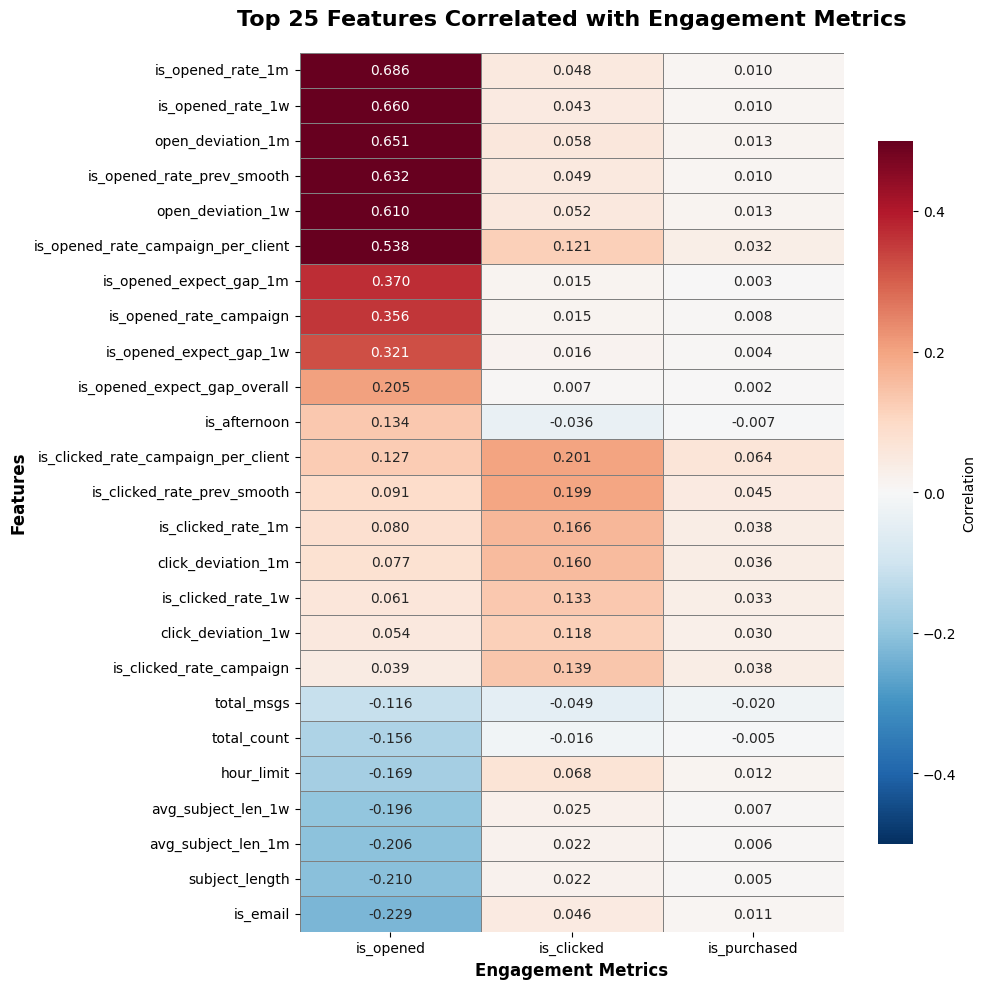


TOP 10 CORRELATIONS FOR EACH TARGET

IS_OPENED:
  is_opened_rate_1m                                  +0.6862
  is_opened_rate_1w                                  +0.6599
  open_deviation_1m                                  +0.6512
  is_opened_rate_prev_smooth                         +0.6317
  open_deviation_1w                                  +0.6096
  is_opened_rate_campaign_per_client                 +0.5381
  is_opened_expect_gap_1m                            +0.3701
  is_opened_rate_campaign                            +0.3557
  is_opened_expect_gap_1w                            +0.3211
  is_email                                           -0.2289

IS_CLICKED:
  is_clicked_rate_campaign_per_client                +0.2007
  is_clicked_rate_prev_smooth                        +0.1989
  is_clicked_rate_1m                                 +0.1659
  click_deviation_1m                                 +0.1596
  is_clicked_rate_campaign                           +0.1391
  is_clicked_rate_1w   

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_simple_correlation_heatmap(df, top_n=25):
    """
    Create a clean correlation heatmap for engagement metrics.
    """
    # Targets
    targets = ['is_opened', 'is_clicked', 'is_purchased']
    
    # Get numeric/boolean columns
    numeric_cols = df.select_dtypes(include=[np.number, 'bool']).columns.tolist()
    
    # Remove IDs and targets from features
    feature_cols = [col for col in numeric_cols 
                   if col not in targets 
                   and not any(x in col.lower() for x in ['_id', 'message_id'])]
    
    print(f"Analyzing {len(feature_cols)} features")
    
    # Compute correlations with each target
    all_correlations = {}
    
    for target in targets:
        if target in df.columns:
            corrs = df[feature_cols].corrwith(df[target])
            all_correlations[target] = corrs
    
    # Combine into DataFrame
    corr_df = pd.DataFrame(all_correlations)
    
    # Get top N features by average absolute correlation
    corr_df['avg_abs'] = corr_df.abs().mean(axis=1)
    top_features = corr_df.nlargest(top_n, 'avg_abs').drop('avg_abs', axis=1)
    
    # Sort by correlation with first target
    top_features = top_features.sort_values(by=targets[0], ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, max(10, top_n * 0.4)))
    
    sns.heatmap(
        top_features,
        annot=True,
        fmt='.3f',
        cmap='RdBu_r',
        center=0,
        vmin=-0.5,
        vmax=0.5,
        cbar_kws={'label': 'Correlation', 'shrink': 0.8},
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    
    ax.set_title(f'Top {top_n} Features Correlated with Engagement Metrics', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Engagement Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Features', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('engagement_correlations.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved: engagement_correlations.png")
    plt.show()
    
    # Print top correlations
    print("\n" + "="*60)
    print("TOP 10 CORRELATIONS FOR EACH TARGET")
    print("="*60)
    
    for target in targets:
        if target in corr_df.columns:
            print(f"\n{target.upper()}:")
            top_10 = corr_df[target].abs().nlargest(10)
            for feat, corr_val in top_10.items():
                actual_corr = corr_df.loc[feat, target]
                print(f"  {feat:50s} {actual_corr:+.4f}")
    
    return corr_df


# Usage
correlations = plot_simple_correlation_heatmap(df, top_n=25)

# EDA

## Summary Statistics and Correlation Analysis

In [58]:
df.sent_count_1m.value_counts()

sent_count_1m
6.0      136617
7.0      131615
5.0      130374
9.0      127852
8.0      125569
          ...  
174.0         2
192.0         1
190.0         1
189.0         1
191.0         1
Name: count, Length: 200, dtype: int64

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Identify new engineered features
eng_features = [
    'is_opened_rate_1w', 'is_opened_rate_1m',
    'is_clicked_rate_1w', 'is_clicked_rate_1m',
    'is_purchased_rate_1w', 'is_purchased_rate_1m',
    'time_to_open_hours', 'time_to_click_hours',
    'avg_time_to_open_1m'
]

target_vars = ['is_opened', 'is_clicked', 'is_purchased']

# --- Summary statistics ---
print("=== Descriptive Statistics ===")
display(df[eng_features].describe())

# --- Correlation with targets ---
print("\n=== Correlation with Targets ===")
corr = df[eng_features + target_vars].corr()[target_vars]
display(corr.style.background_gradient(cmap="coolwarm"))


=== Descriptive Statistics ===


,is_opened_rate_1w,is_opened_rate_1m,is_clicked_rate_1w,is_clicked_rate_1m,is_purchased_rate_1w,is_purchased_rate_1m,time_to_open_hours,time_to_click_hours,avg_time_to_open_1m
count,1.312607e+06,1.568469e+06,1.312607e+06,1.568469e+06,1.312607e+06,1.568469e+06,313151.000000,17767.000000,630152.000000
mean,1.998148e-01,1.907308e-01,1.168336e-02,1.216630e-02,5.574653e-04,4.652791e-04,33.214720,21.709727,35.910037
std,3.589041e-01,3.146944e-01,8.189191e-02,6.012381e-02,1.190852e-02,9.319575e-03,271.972804,137.451936,267.203135
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.023889,-0.000278,-0.008611
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000833,0.260972,0.002778
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.003889,2.002222,0.299417
75%,2.500000e-01,2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.545000,12.617361,7.293056
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,11515.181111,8529.672500,11515.181111



=== Correlation with Targets ===


,is_opened,is_clicked,is_purchased
is_opened_rate_1w,0.659927,0.043290,0.009878
is_opened_rate_1m,0.686160,0.047926,0.009805
is_clicked_rate_1w,0.060746,0.133000,0.033065
is_clicked_rate_1m,0.079883,0.165870,0.037775
is_purchased_rate_1w,0.032735,0.056691,0.027762
is_purchased_rate_1m,0.031718,0.054821,0.031742
time_to_open_hours,nan,-0.011476,-0.003435
time_to_click_hours,0.037928,nan,-0.006881
avg_time_to_open_1m,-0.014139,-0.002154,-0.001168
is_opened,1.000000,0.186799,0.035921


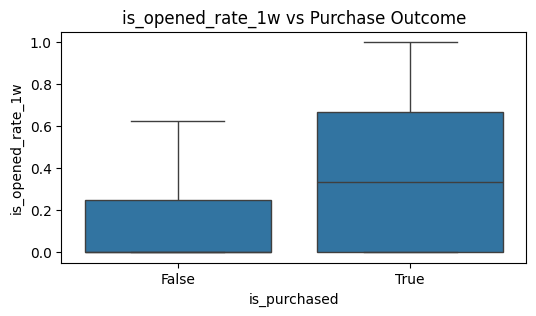

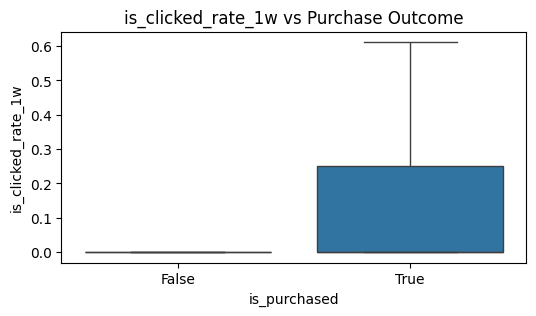

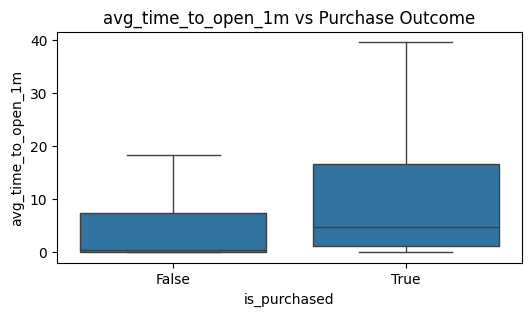

In [50]:
for col in ['is_opened_rate_1w', 'is_clicked_rate_1w', 'avg_time_to_open_1m']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='is_purchased', y=col, data=df, showfliers=False)
    plt.title(f"{col} vs Purchase Outcome")
    plt.show()

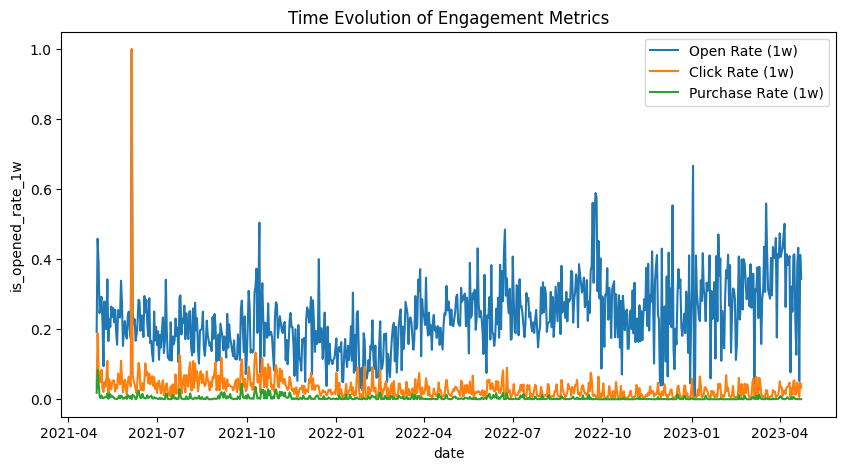

In [53]:
daily_engagement = (
    df.groupby('date')[['is_opened_rate_1w', 'is_clicked_rate_1w', 'is_purchased_rate_1w']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_engagement, x='date', y='is_opened_rate_1w', label='Open Rate (1w)')
sns.lineplot(data=daily_engagement, x='date', y='is_clicked_rate_1w', label='Click Rate (1w)')
sns.lineplot(data=daily_engagement, x='date', y='is_purchased_rate_1w', label='Purchase Rate (1w)')
plt.title("Time Evolution of Engagement Metrics")
plt.legend()
plt.show()


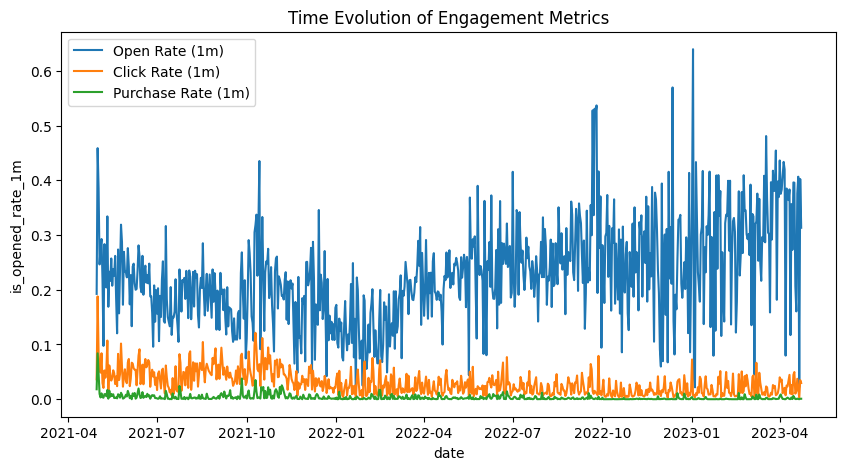

In [55]:
daily_engagement = (
    df.groupby('date')[['is_opened_rate_1m', 'is_clicked_rate_1m', 'is_purchased_rate_1m']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_engagement, x='date', y='is_opened_rate_1m', label='Open Rate (1m)')
sns.lineplot(data=daily_engagement, x='date', y='is_clicked_rate_1m', label='Click Rate (1m)')
sns.lineplot(data=daily_engagement, x='date', y='is_purchased_rate_1m', label='Purchase Rate (1m)')
plt.title("Time Evolution of Engagement Metrics")
plt.legend()
plt.show()
